<a href="https://colab.research.google.com/github/JuanArmas/BigData7RO/blob/main/EjercicioRedesConvolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autor: Juan Armas Aleman



Github: https://github.com/JuanArmas/BigData7RO/blob/main/EjercicioRedesConvolucionales.ipynb

Drive: https://drive.google.com/drive/folders/1lrypu655juvWbsoflUMi1A37gNKKawjt?usp=sharing

In [1]:
import os
import cv2
import glob
import keras
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras import regularizers
from google.colab import drive
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import to_categorical
from keras.regularizers import l1 , l2, l1_l2
from keras.layers import Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, Flatten

# from mpl_toolkits.mplot3d import Axes3D




#Carga y normalización de datos

In [2]:
# Generamos acceso al drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carga de los datos del drive y creacion de la carpeta donde se almacenarán las imagenes una vez procesadas y normalizadas

In [3]:
# Cargamos la información del drive para poder acceder a ella
input_images_path = "/content/drive/MyDrive/Chess/"
output_images_path = "/content/drive/MyDrive/ChessProcessed/"

# Crear el directorio de salida si no existe
if not os.path.exists(output_images_path):
    os.makedirs(output_images_path)
    print("Directorio creado: ", output_images_path)


Obtenemos la lista de carpetas donde estarán las distintas imágenes

In [4]:
# Listar las carpetas de piezas
piece_folders = os.listdir(input_images_path)

piece_folders

['Rook', 'Knight', 'Queen', 'Pawn', 'Bishop', 'King']

# Estandarizamos todas las imágenes a tamaño 64 x 64



In [5]:
# img_rows,img_cols = 128,117
img_rows,img_cols = 64,64

# Tamaño de las imágenes
imagen_ancho = img_rows
imagen_alto = img_cols

# Número de clases
numero_clases = 6
imagen_ancho,imagen_alto

(64, 64)

Las imágenes sintéticas generadas por el Data augmentation, se deberán almacenar en una carpeta predeterminada. Al iniciar el algoritmo este verificará si la carpeta ya existe y si es así, la borrará y la creará de nuevo. Esta medida se toma debido a que las imágenes sintéticas se irán creando cada vez que se ejecute el código y por lo tanto, para evitar su crecimiento exponencial con cada ejecución.

In [6]:
# Crear el directorio de salida si no existe
if not os.path.exists(output_images_path):
  os.makedirs(output_images_path)
else:
  shutil.rmtree(output_images_path) #se borrará la carpeta con todo su contenido
  os.makedirs(output_images_path) # se creará de nuevo la carpeta vacía

Se definen hiperparámetros y se crean distintas listas donde irán almacenandose las imágenes en distitnos estados de procesamiento.

Los hiperparámetros que definimos aquí indican las características de las imágenes. Iniciamos las dimensiones, rangos de brillos y porcentaje de rotación para el Data augmentation.

In [7]:
# definir dimensiones de las imagenes
image_size = imagen_ancho,imagen_alto
# Lista para almacenar todas las imágenes (todas y redimensionadas)
all_images = []
resized_image = []

# Lista para almacenar todas las etiquetas
all_labels = []

# Definir las técnicas de Data Augmentation
brightness_range = (-0.1, 0.1)
rotation_range = 20

En este bucle es donde se trabaja y modifican las imágenes, es la primera parte de la normalización y tratamiento de datos que le pasaremos a la red neuronal.

Inicialmente se recorren todas las carpetas que están dentro de la carpeta input_images_path y se crean rutas a las distintas carpetas para ir accediendo a ellas y extraer las imágenes.

Los nombres de estas imágenes se van almacenando en file_name y se va diferenciando las que iteresan de las que no. En este caso, dentro de todos los archivos que se encuentran en la carpeta original, se diferencia entre los que tengan determinadas extensiones de imágenes válidas y se cargan en la lista "image".

Se redimensionan las imagenes originales a 64x64 y se van añadiendo a las listas las imágenes, y los indices a la lista labels.

Sobre las originales aplicamos el aumento de datos sitéticos, aplicando los hiperparámetros para generar distintas muestras. y se redimensionan a la misma escala que los datos originales.

Finalmente se añaden estas muestras sintéticas a la lista donde se encuentran los datos originales

In [8]:
# Recorrer las carpetas de piezas
for label, piece_folder in enumerate(os.listdir(input_images_path)):
  piece_path = os.path.join(input_images_path, piece_folder)

  # Almacenar las imágenes originales y generar aumentadas
  for file_name in os.listdir(piece_path):
    if file_name.endswith(('.jpg', '.jpeg', '.png')):
      image_path = os.path.join(piece_path, file_name)
      image = cv2.imread(image_path, cv2.IMREAD_COLOR)

      # Redimensionar la imagen
      resized_image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
      # print(resized_image.shape)  # Imprime la forma de la imagen actual

      # Almacenar imagen original
      all_images.append(resized_image)
      all_labels.append(int(label))

      # Aplicar Data Augmentation (brillo y rotación)
      augmented_image_brightness = tf.keras.preprocessing.image.random_brightness(image.copy(), brightness_range, scale=True)
      augmented_image_rotation = tf.keras.preprocessing.image.random_rotation(image.copy(), rotation_range)

      # Redimensionar las imágenes aumentadas
      resized_image_brightness = cv2.resize(augmented_image_brightness, image_size, interpolation=cv2.INTER_AREA)
      resized_image_rotation = cv2.resize(augmented_image_rotation, image_size, interpolation=cv2.INTER_AREA)

      # Guardar imágenes aumentadas con nombre único
      new_file_name_brightness = f"{file_name}_brightness_{random.randint(1, 1000)}.jpg"
      cv2.imwrite(os.path.join(output_images_path, new_file_name_brightness), resized_image_brightness)
      all_images.append(resized_image_brightness)
      all_labels.append(int(label))

      new_file_name_rotation = f"{file_name}_rotation_{random.randint(1, 1000)}.jpg"
      cv2.imwrite(os.path.join(output_images_path, new_file_name_rotation), resized_image_rotation)
      all_images.append(resized_image_rotation)
      all_labels.append(int(label))

Convertimos las listas en arrays de numpy

In [9]:
# desordenar las listas con:

data = np.array(all_images)
labels = np.array(all_labels)

perm = np.random.permutation(len(data))
data, labels = data[perm], labels[perm]

# División del conjunto de datos train, test, validación

En este punto generamos los datos de entrenamiento y validación y le asignamos un 80% a entrenamiento y un 20% a repartir entre test y validation.

In [10]:
# Codificar las etiquetas categóricamente con el número correcto de clases (6)
labels = to_categorical(labels, num_classes=6)

split_train = int(0.8 * len(data))  # 80% para entrenamiento
split_test = int(0.1 * len(data))  # 10% para test
split_val = int(0.1 * len(data))    # 10% para validación

# Se marcan las limitaciones en las listas que están destinadas a cada conjunto de datos
X_train, y_train = data[:split_train], labels[:split_train]
X_val, y_val = data[split_train:split_val], labels[split_train:split_val]
X_test, y_test = data[split_val:], labels[split_val:]

# Ejecución de la Red convolucional

Pasamos ya a la red neuronal.
Es una red con una capa inicial con función de activacion Relu, un kernel de 3x3 que indicará la ventana que usará la red para ir analizando cada imagen pixel a pixel y 32 neuronas. Se compone de dos capas densas intermedias de 64 y 128 neuronas, con una inicializacion de bias random uniform y los regularizadores del kernel L1 y L2, que recordemos que son dos técnicas de regularización que se utilizan para evitar el sobreajuste de la red neuronal. Ambas penalizan la complejidad del modelo. A su vez, a ambas le siguen capas de maxpooling de 2x2, donde se irá controlando las dimensiones de las propias imagenes y el batch normalization que también ayudará a controlar la extensión de cada batch de datos. Se aplica un dropout del 50% antes de la capa final densa con 6 neuronas y función Softmax para la clasificación, para la eliminación de las neuronas que no vayan cumpliendo con un minimo de accuracy y también se le aplica una capa flatten, para aplanar el conjunto de neuronas restantes a la salida

In [11]:
# # Construir el modelo CNN -> prueba 2.2
model = keras.Sequential([
keras.layers.Conv2D(32, kernel_size=(3, 3), input_shape=(img_rows,img_cols, 3), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(64, activation='relu',bias_initializer='random_uniform', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(128, activation='relu', bias_initializer='random_uniform', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(),
    # keras.layers.Dense(64, activation='relu', bias_initializer='random_uniform', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)),
    # keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(6, activation='softmax')
])

Finalmente compilamos el modelo usando el optimizador Adam para su preprocesamiento, loss y metricas usuales (categorical crossentropy y accuracy) y mostramos la gráfica de loss y accuracy para los datos de train, test y validation

Epoch 1/10
40/40 [==============================] - 9s 185ms/step - loss: 5.1071 - accuracy: 0.2335 - val_loss: 5.2683 - val_accuracy: 0.1538
Epoch 2/10
40/40 [==============================] - 7s 173ms/step - loss: 3.1557 - accuracy: 0.3805 - val_loss: 4.2510 - val_accuracy: 0.1923
Epoch 3/10
40/40 [==============================] - 6s 149ms/step - loss: 2.5864 - accuracy: 0.5024 - val_loss: 3.7302 - val_accuracy: 0.4231
Epoch 4/10
40/40 [==============================] - 7s 166ms/step - loss: 2.2611 - accuracy: 0.5770 - val_loss: 3.7009 - val_accuracy: 0.2692
Epoch 5/10
40/40 [==============================] - 8s 207ms/step - loss: 2.0937 - accuracy: 0.6046 - val_loss: 4.9761 - val_accuracy: 0.2308
Epoch 6/10
40/40 [==============================] - 7s 174ms/step - loss: 2.1182 - accuracy: 0.6085 - val_loss: 4.8108 - val_accuracy: 0.2308
Epoch 7/10
40/40 [==============================] - 7s 187ms/step - loss: 2.0358 - accuracy: 0.6266 - val_loss: 4.8750 - val_accuracy: 0.3846
Epoch 

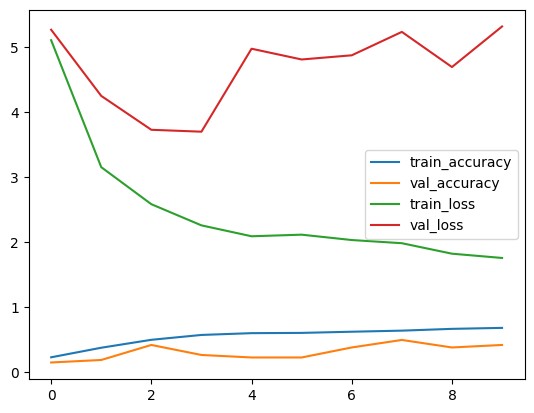

In [12]:
# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split = 0.02)
# history = model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split = 0.02)

# Evaluar el modelo

accuracy = model.evaluate(X_test, y_test)[1]
# accuracy = model2.evaluate(X_test, y_test)[1]
print(f"Accuracy: {accuracy * 100:.2f}%")


# Visualización de la precisión y la pérdida durante el entrenamiento
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Realizamos la predicción del modelo

41/41 [==============================] - 2s 36ms/step


La red predice que la primera imagen pertenece a la clase 2
Probabilidad de la clase predicha: 0.3366257846355438


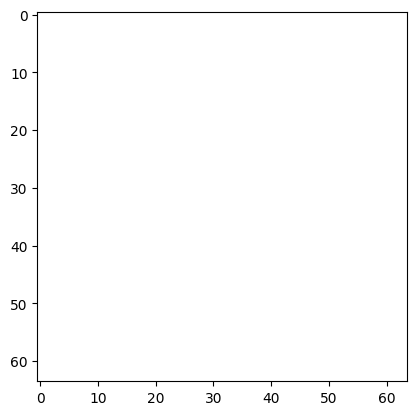

Clase predicha: Knight


In [13]:
# Esta variable contiene un mapeo de número de clase a Pieza.
MAP_CHARACTERS = {0: 'Bishop', 1: 'King', 2: 'Knight', 3: 'Pawn', 4: 'Queen', 5: 'Rook'}

predictions = model.predict(X_train)

# Obtener la predicción para la primera imagen del conjunto de entrenamiento
predicted_class = np.argmax(predictions[0])

# Imprimir la clase predicha para la primera imagen
print(f"La red predice que la primera imagen pertenece a la clase {predicted_class}")

# Imprimir la probabilidad de la clase predicha
print(f"Probabilidad de la clase predicha: {predictions[0][predicted_class]}")

def show_prediction(image, predicted_class, class_map):
  """
  Muestra la imagen, la clase predicha y el nombre de la clase.

  Args:
    image: La imagen a mostrar.
    predicted_class: El índice de la clase predicha.
    class_map: Un mapeo de número de clase a nombre de clase.
  """

  # Mostrar la imagen
  plt.imshow(image)
  plt.show()

  # Obtener el nombre de la clase
  class_name = class_map[predicted_class]

  # Imprimir la información
  print(f"Clase predicha: {class_name}")

# Mostrar la imagen con la clase predicha
show_prediction(X_train[0], predicted_class, MAP_CHARACTERS)